In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

df = pd.read_json('20251115_200000-mnli_sample_weights-1/eval_predictions.jsonl', lines=True)
cols = ['pairID', 'label', 'predicted_label', 'predicted_scores']
df = df[cols]
df['weights'] = 1.0
df.head()

,pairID,label,predicted_label,predicted_scores,weights
0,31193n,1,0,"[0.750022053718566, 0.275623768568038, -1.0600...",1.0
1,101457e,0,1,"[-1.0573924779891961, 0.980648458003997, -0.07...",1.0
2,134793e,0,1,"[-0.098487757146358, 0.981302678585052, -1.032...",1.0
3,37397e,0,1,"[-1.138328313827514, 2.384851932525634, -1.670...",1.0
4,50563n,1,0,"[0.6810731291770931, 0.606830835342407, -1.395...",1.0


In [25]:
correct = df["label"] == df["predicted_label"]
df["confidence"] = df["predicted_scores"].apply(max)
correct_conf = df.loc[correct, "confidence"]
max_conf, min_conf = correct_conf.max(), correct_conf.min()

eps = 1e-4

if max_conf > min_conf:
    df.loc[correct, "weights"] = (correct_conf - min_conf) / (max_conf - min_conf + eps)
else:
    df.loc[correct, "weights"] = 0.001

df


,pairID,label,predicted_label,predicted_scores,weights,confidence
0,31193n,1,0,"[0.750022053718566, 0.275623768568038, -1.0600...",1.000000,0.750022
1,101457e,0,1,"[-1.0573924779891961, 0.980648458003997, -0.07...",1.000000,0.980648
2,134793e,0,1,"[-0.098487757146358, 0.981302678585052, -1.032...",1.000000,0.981303
3,37397e,0,1,"[-1.138328313827514, 2.384851932525634, -1.670...",1.000000,2.384852
4,50563n,1,0,"[0.6810731291770931, 0.606830835342407, -1.395...",1.000000,0.681073
...,...,...,...,...,...,...
392697,30418c,2,2,"[-1.374484777450561, -0.29814925789833, 1.4308...",0.449569,1.430845
392698,105454n,1,1,"[-0.280571609735488, 0.530377864837646, -0.293...",0.162755,0.530378
392699,13960e,0,1,"[-1.255748271942138, 1.234199523925781, -0.189...",1.000000,1.234200
392700,114061n,1,1,"[-0.8667144179344171, 1.414031982421875, -0.77...",0.444214,1.414032


count    392702.000000
mean          0.741199
std           0.315553
min           0.000000
25%           0.424135
50%           1.000000
75%           1.000000
max           1.000000
Name: weights, dtype: float64


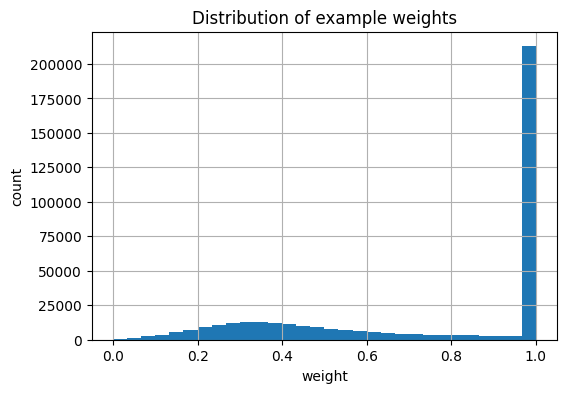

In [26]:
print(df['weights'].describe())
plt.figure(figsize=(6, 4))
df["weights"].hist(bins=30)
plt.xlabel("weight")
plt.ylabel("count")
plt.title("Distribution of example weights")
plt.show()

In [28]:
total = len(df)

# 1. Weight == 1.0
num_one = (df["weights"] == 1.0).sum()
pct_one = num_one / total * 100

# 2. Weight < 1.0
num_less = (df["weights"] < 1.0).sum()
pct_less = num_less / total * 100

# 3. Avg of weights < 1.0
avg_less = df.loc[df["weights"] < 1.0, "weights"].mean()

print(f"Total examples: {total}")
print()
print(f"Weight == 1.0 → {num_one} examples ({pct_one:.2f}%)")
print(f"Weight < 1.0  → {num_less} examples ({pct_less:.2f}%)")
print(f"Average weight among < 1.0: {avg_less:.6f}")

Total examples: 392702

Weight == 1.0 → 210818 examples (53.68%)
Weight < 1.0  → 181884 examples (46.32%)
Average weight among < 1.0: 0.441228


In [27]:
# Build a plain Python dict
weight_dict = {}

for _, row in df.iterrows():
    pid = str(row["pairID"])      # make sure JSON keys are strings
    wt  = float(row["weights"])   # ensure clean float values
    weight_dict[pid] = wt

# Write it out
with open("20251115_200000-mnli_sample_weights-1/mnli_weights.json", "w") as f:
    json.dump(weight_dict, f, indent=2)